In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForMaskedLM
import pandas as pd
import torch.nn.functional as F
import numpy as np
from scipy.stats import entropy
import logging
from collections import defaultdict
from tqdm.auto import tqdm
import os
import matplotlib.pyplot as plt
from typing import Dict, List
import json
import datetime
import warnings
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, classification_report
warnings.filterwarnings("ignore")

## Class pour charger le Corpus de Test

### Objectif principal

La classe permet de :
1. Charger un ensemble de textes et leurs niveaux CEFR.
2. Convertir les niveaux CEFR en valeurs numériques pour simplifier le traitement.
3. Tokeniser les textes en utilisant un tokenizer BERT.
4. Préparer des données pour un apprentissage supervisé en masquant certains tokens selon une stratégie spécifique (utilisée dans des modèles comme BERT).

### Fonctionnalités principales

#### 1. **Initialisation (`__init__`)**
   - Reçoit les paramètres suivants :
     - `texts`: une liste de textes.
     - `cefr_levels`: une liste de niveaux CEFR associés aux textes (exemple : `A1`, `B2`).
     - `tokenizer`: un tokenizer compatible avec BERT.
     - `max_length`: longueur maximale des séquences (par défaut : 512).
   - Convertit les niveaux CEFR en valeurs numériques à l'aide d'un dictionnaire (`A1` = 1, ..., `C2` = 6) pour faciliter le traitement.

#### 2. **Taille des données (`__len__`)**
   - Retourne le nombre total de textes dans le dataset.

#### 3. **Accès aux données (`__getitem__`)**
   - Prend un index `idx` en entrée et retourne un exemple de données transformées.
   - Les étapes de transformation sont :
     1. **Tokenisation** :
        - Le texte correspondant à l'index `idx` est tokenisé.
        - La tokenisation produit :
          - `input_ids`: une liste d'identifiants numériques pour chaque token.
          - `attention_mask`: masque binaire indiquant les positions valides (1) ou de remplissage (0).
     2. **Création d'une version masquée des tokens** :
        - 15 % des tokens valides (pas de padding) sont masqués.
        - Masquage effectué selon la stratégie :
          - 80 % sont remplacés par un token `[MASK]`.
          - 10 % sont remplacés par un token aléatoire.
          - 10 % restent inchangés.
     3. **Retour des données** :
        - Les données transformées incluent :
          - `input_ids` : la séquence avec masquage.
          - `attention_mask` : le masque d'attention.
          - `labels` : la séquence originale avant masquage (utilisée pour la supervision).
          - `level` : le niveau CEFR converti en valeur numérique.

In [ ]:
class CEFRDialangDataset(Dataset):
    """
    Classe pour le chargement des données du corpus CEFR Dialang.
    """

    def __init__(
        self,
        texts: List[str],
        cefr_levels: List[str],
        tokenizer: BertTokenizer,
        max_length: int = 512
    ):
        self.texts = texts
        self.cefr_levels = cefr_levels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Convertit les niveaux CEFR en valeurs numériques
        self.cefr_to_num = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}
        self.numeric_levels = [self.cefr_to_num.get(level, 0) for level in cefr_levels]  # 0 pour les niveaux inconnus

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        level = self.numeric_levels[idx]

        # Tokenise le texte
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze() # squeeze pour enlever la dimension 1

        attention_mask = encoding['attention_mask'].squeeze()

        # Crée une copie des input_ids pour les tokens masqués (D'après l'article - 15% des tokens)
        masked_input_ids = input_ids.clone()

        # Masque uniquement les tokens valides (pas le padding)
        valid_positions = attention_mask.bool()

        # Calcule le nombre de tokens à masquer (15% des tokens valides)
        n_tokens = valid_positions.sum().item()
        n_to_mask = max(1, round(0.15 * n_tokens))

        # Selectionne aléatoirement les positions à masquer
        valid_positions_idx = valid_positions.nonzero().squeeze()
        if valid_positions_idx.dim() == 0:  # Cas où il n'y a qu'un seul token
            valid_positions_idx = valid_positions_idx.unsqueeze(0)
        positions_to_mask = valid_positions_idx[torch.randperm(len(valid_positions_idx))[:n_to_mask]]

        # Appliquer la stratégie de masking (80-10-10)
        for position in positions_to_mask:
            prob = torch.rand(1).item()
            if prob < 0.8:
                masked_input_ids[position] = self.tokenizer.mask_token_id
            elif prob < 0.9:
                # Remplace par un token aléatoire
                masked_input_ids[position] = torch.randint(0, self.tokenizer.vocab_size, (1,))

        return {
            'input_ids': masked_input_ids,
            'attention_mask': attention_mask,
            'labels': input_ids,
            'level': torch.tensor(level, dtype=torch.long)
        }

In [ ]:
def get_device() -> torch.device:
    """
    Détermine et retourne le périphérique d'exécution (device) le plus approprié pour les calculs PyTorch.

    Cette fonction sélectionne automatiquement le meilleur périphérique disponible parmi :
    - **MPS (Metal Performance Shaders)** : utilisé sur les machines Apple équipées de GPU compatibles.
    - **CUDA** : utilisé sur les machines avec des GPU NVIDIA compatibles CUDA.
    - **CPU** : utilisé par défaut si aucun GPU n'est disponible.

    Le périphérique sélectionné est affiché via un message dans la console.

    Retourne :
        torch.device : Une instance de `torch.device` représentant le périphérique sélectionné.
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")  # Utilise le GPU compatible Metal (MPS) si disponible.
        print("Using MPS device")
    elif torch.cuda.is_available():
        device = torch.device("cuda")  # Utilise un GPU compatible CUDA si disponible.
        print("Using CUDA device")
    else:
        device = torch.device("cpu")  # Par défaut, utilise le CPU.
        print("Using CPU")
    return device

## Préparation des données

### 1. **Sélection du Périphérique**
- Le périphérique d'exécution (CPU, CUDA ou MPS) est sélectionné automatiquement à l'aide de la fonction `get_device()`.
- Le choix du périphérique est affiché dans la console.

### 2. **Chargement et Préparation des Données**
***Remarque : Étant donné que l'évaluation sur le corpus complet entraîne toujours la déconnection de l'environnement, ici on prend seulement les 200 premiers textes du corpus.***
- **Source des données** : Les données sont lues depuis un fichier CSV contenant des textes annotés avec des niveaux CEFR.
- **Filtrage** : Seules les 200 premières lignes sont conservées pour limiter la taille du corpus.
- **Nettoyage des textes** :
  - Suppression des balises HTML avec une expression régulière.
  - Remplacement des espaces multiples par un espace unique.
- **Extraction des niveaux CEFR** :
  - Les niveaux textuels (`A1`, `B2`, etc.) sont extraits et convertis en valeurs numériques (`A1` = 1, ..., `C2` = 6).
  - Les niveaux non reconnus sont mappés à `0`.

### 3. **Chargement des Modèles et Tokenizer**
- Fonction `charger_modele()` :
  - **Modèles chargés** :
    - `bert_base` : Modèle de base BERT pour les tâches de masquage de langage.
    - `EFCAMDAT` : Modèle BERT personnalisé, entraîné sur un corpus spécifique (EFCAMDAT).
  - **Tokenizer** : Chargé depuis le même chemin que le modèle personnalisé.
- Les modèles sont configurés en mode évaluation (`eval()`) et envoyés sur le périphérique sélectionné.

### 4. **Préparation des Données pour l'Évaluation**
- Les textes et leurs niveaux CEFR numériques sont encapsulés dans une classe personnalisée, `CEFRDialangDataset`, compatible avec PyTorch.
- Les données sont passées à un **DataLoader** qui :
  - Divise les données en **batchs** de taille 8.
  - Active des optimisations mémoire si un GPU est utilisé (`pin_memory`).

### 5. **Initialisation des Résultats**
- Un dictionnaire, `eval_results_4_models`, est créé pour stocker les résultats d'évaluation des deux modèles (`Bert-base` et `EFCAMDAT`).

In [ ]:
# Sélectionne le périphérique d'exécution (CPU, CUDA ou MPS) pour les calculs.
device = get_device()

# Chargement du fichier CSV contenant le corpus de test.
df_Test = pd.read_csv("/content/drive/MyDrive/Doc_Struct_Projet/corpus_test/data_public_anglais_annotated_CEFR_dialang.csv")

# Limite le dataframe aux 200 premières lignes pour réduire la taille du corpus.
df_Test = df_Test.head(200)

# Nettoyage des textes des étudiants :
# - Suppression des balises HTML (<...>) avec une expression régulière.
# - Remplacement des espaces multiples par un seul espace.
# - Conversion des textes nettoyés en une liste.
texts = df_Test['Texte_etudiant'].str.replace(r"<[^>]+>", "", regex=True).str.replace(r"\s{2,}", " ", regex=True).tolist()

# Extraction des étiquettes (niveaux CEFR) depuis la colonne correspondante.
labels = df_Test['Note_dialang_ecrit'].tolist()

# Conversion des niveaux CEFR textuels ('A1', 'B2', etc.) en valeurs numériques (1 pour A1, ..., 6 pour C2).
# Si un niveau n'est pas reconnu, il est mappé à 0 par défaut.
cefr_to_num = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}
numeric_levels = [cefr_to_num.get(level, 0) for level in labels]

# Définition d'une fonction pour charger les modèles et le tokenizer.
def charger_modele():
    """
    Charge les modèles BERT nécessaires pour l'évaluation et le tokenizer associé.

    Modèles chargés :
    - bert_base : Le modèle BERT de base non entraîné.
    - EFCAMDAT : Un modèle BERT personnalisé entraîné sur le corpus EFCAMDAT.

    Retourne :
        tuple : (tokenizer, bert_base, EFCAMDAT)
    """
    # Chargement du modèle BERT de base pour les tâches de masquage de langage.
    bert_base = BertForMaskedLM.from_pretrained(
        "bert-base-uncased",
        trust_remote_code=True,
        ignore_mismatched_sizes=True
    )

    # Chemin du modèle personnalisé EFCAMDAT et du tokenizer associé.
    model_path = "/content/drive/MyDrive/Doc_Struct_Projet/EFCamDAT_scripts/bert-efcamdat-m3/best_model"

    # Chargement du tokenizer associé au modèle personnalisé.
    tokenizer = BertTokenizer.from_pretrained(model_path, use_fast=True)

    # Chargement du modèle EFCAMDAT personnalisé.
    EFCAMDAT = BertForMaskedLM.from_pretrained(
        model_path,
        trust_remote_code=True,
        ignore_mismatched_sizes=True
    )

    return tokenizer, bert_base, EFCAMDAT

# Chargement des modèles et du tokenizer.
tokenizer, bert_base, EFCAMDAT = charger_modele()

# Mise en mode évaluation (inférence) des modèles.
bert_base.eval()
EFCAMDAT.eval()

# Envoi des modèles sur le périphérique d'exécution sélectionné (CPU, CUDA ou MPS).
bert_base.to(device)
EFCAMDAT.to(device)

# Création d'un dataset personnalisé (CEFRDialangDataset) avec les textes et niveaux numériques.
Corpus_Test = CEFRDialangDataset(texts, numeric_levels, tokenizer)

# Préparation d'un DataLoader pour parcourir les données en batchs pendant l'inférence.
data_loader = DataLoader(
    Corpus_Test,
    batch_size=8,  # Taille de batch de 8.
    shuffle=False,  # Pas de mélange des données, ordre inchangé.
    num_workers=0,  # Nombre de threads utilisés pour le chargement des données.
    pin_memory=True if device.type != "cpu" else False  # Optimisation mémoire si on utilise un GPU.
)

# Initialisation d'un dictionnaire pour stocker les résultats d'évaluation des modèles.
eval_results_4_models = {"Bert-base": {}, "EFCAMDAT": {}}

Using CPU


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

## Évaluation

### Évaluation de l'Accuracy

In [ ]:
# Fonction pour calculer l'accuracy d'un batch
def calculate_accuracy(predictions, labels):
    """
    Calcule l'accuracy pour un batch de données.

    Cette fonction compare les prédictions du modèle aux labels réels, en ignorant les
    positions contenant des tokens paddés (indiqués par -100).

    Arguments :
        predictions (torch.Tensor) : Les logits des prédictions du modèle de taille (batch_size, sequence_length, vocab_size).
        labels (torch.Tensor) : Les labels réels de taille (batch_size, sequence_length).

    Retourne :
        float : L'accuracy pour le batch, en tant que ratio des prédictions correctes.
    """
    # Trouver les tokens prédits en prenant le maximum sur la dimension du vocabulaire.
    pred_tokens = predictions.argmax(dim=-1)

    # Comparer les prédictions aux labels réels, tout en ignorant les tokens paddés (-100).
    correct = (pred_tokens == labels) & (labels != -100)

    # Calculer et retourner la moyenne des prédictions correctes.
    return correct.float().mean().item()


# Fonction pour évaluer l'accuracy d'un modèle sur l'ensemble des données
def model_accuracy(model, data_loader, tokenizer, device):
    """
    Évalue les performances d'un modèle sur un dataset, en calculant la perte moyenne et l'accuracy des tokens masqués.

    Arguments :
        model (torch.nn.Module) : Le modèle à évaluer.
        data_loader (torch.utils.data.DataLoader) : Le DataLoader contenant les données d'évaluation.
        tokenizer (BertTokenizer) : Le tokenizer utilisé pour la préparation des données.
        device (torch.device) : Le périphérique d'exécution (CPU, CUDA, ou MPS).

    Retourne :
        tuple : Moyenne de la perte et accuracy des tokens masqués.
    """
    total_loss = 0  # Accumulateur pour la perte totale.
    masked_correct_predictions = 0  # Compteur pour les prédictions correctes sur les tokens masqués.
    masked_tokens = 0  # Compteur pour le nombre total de tokens masqués.

    # Désactivation des gradients pour l'inférence.
    with torch.no_grad():
        for batch in data_loader:
            # Récupération des données et transfert vers le périphérique.
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass pour obtenir la perte et les logits.
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Accumuler la perte pour calculer la moyenne.
            total_loss += loss.item()

            # Identification des positions valides pour les tokens masqués (non-paddés).
            masked_positions = labels != tokenizer.pad_token_id
            predictions = torch.argmax(logits, dim=-1)  # Trouver les prédictions les plus probables.

            # Filtrer les positions valides en excluant les labels -100 (utilisés pour le padding).
            valid_masked_positions = masked_positions & (labels != -100)

            # Calcul des prédictions correctes et des tokens masqués valides.
            masked_correct_predictions += ((predictions == labels) & valid_masked_positions).sum().item()
            masked_tokens += valid_masked_positions.sum().item()

    # Calculer la perte moyenne.
    average_loss = total_loss / len(data_loader)

    # Calculer l'accuracy des tokens masqués, en évitant la division par zéro.
    if masked_tokens > 0:
        masked_token_accuracy = masked_correct_predictions / masked_tokens
    else:
        masked_token_accuracy = 0

    # Afficher les métriques d'évaluation.
    print(f"Evaluation Loss: {average_loss:.4f}")
    print(f"Token Accuracy: {masked_token_accuracy:.4f}")

    # Retourner la perte moyenne et l'accuracy des tokens masqués.
    return average_loss, masked_token_accuracy


# Évaluation du modèle BERT de base.
average_loss, masked_token_accuracy = model_accuracy(bert_base, data_loader, tokenizer, device)
eval_results_4_models["Bert-base"]["average_loss"], eval_results_4_models["Bert-base"]["masked_token_accuracy"] = average_loss, masked_token_accuracy

# Évaluation du modèle EFCAMDAT.
average_loss, masked_token_accuracy = model_accuracy(EFCAMDAT, data_loader, tokenizer, device)
eval_results_4_models["EFCAMDAT"]["average_loss"], eval_results_4_models["EFCAMDAT"]["masked_token_accuracy"] = average_loss, masked_token_accuracy

# Sauvegarde des résultats d'évaluation dans un fichier pickle.
with open('/content/drive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/eval_results_4_models_only_global_metrics.pickle', 'wb') as handle:
    pickle.dump(eval_results_4_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

Evaluation Loss: 9.7391
Token Accuracy: 0.8871
Evaluation Loss: 0.2281
Token Accuracy: 0.9235


### Évaluation Recall at k (recall@k)

In [ ]:
# Fonction pour calculer le Recall@k
def calculate_recall_at_k(model, data_loader, tokenizer, device, k=5):
    """
    Calcule le Recall@k pour un modèle sur un ensemble de données donné.

    Le Recall@k mesure la proportion des tokens cibles (labels) qui figurent parmi les k prédictions les plus probables pour chaque position valide.

    Arguments :
        model (torch.nn.Module) : Le modèle à évaluer.
        data_loader (torch.utils.data.DataLoader) : Le DataLoader contenant les données d'évaluation.
        tokenizer (BertTokenizer) : Le tokenizer utilisé pour préparer les données.
        device (torch.device) : Le périphérique d'exécution (CPU, CUDA ou MPS).
        k (int) : Le nombre de prédictions les plus probables à considérer.

    Retourne :
        float : Le Recall@k pour l'ensemble des données.
    """
    total_recall = 0  # Compteur pour les labels correctement prédits dans le top-k.
    total_samples = 0  # Compteur du nombre total de labels valides.

    # Désactivation des gradients pour l'inférence.
    with torch.no_grad():
        for batch in data_loader:
            # Récupération des données du batch et transfert vers le périphérique.
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass pour obtenir les logits.
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Logits de taille (batch_size, seq_length, vocab_size).

            # Récupération des k prédictions les plus probables pour chaque token.
            top_k_predictions = torch.topk(logits, k, dim=-1).indices  # Taille : (batch_size, seq_length, k).

            # Identification des positions valides (labels non paddés et non masqués).
            masked_positions = (labels != tokenizer.pad_token_id) & (labels != -100)

            # Extraction des labels et des prédictions correspondants aux positions valides.
            valid_labels = labels[masked_positions]  # Labels aplatis.
            valid_predictions = top_k_predictions[masked_positions]  # Prédictions aplaties.

            # Vérification si les labels réels figurent dans le top-k prédictions.
            recall_matches = (valid_labels.unsqueeze(-1) == valid_predictions).any(dim=-1)

            # Mise à jour des compteurs pour le calcul du Recall@k.
            total_recall += recall_matches.sum().item()
            total_samples += valid_labels.size(0)

    # Calcul du Recall@k pour l'ensemble des données.
    recall_at_k = total_recall / total_samples if total_samples > 0 else 0
    return recall_at_k


# Évaluation du Recall@k pour différents k (1, 5, 10).
k_list = [1, 5, 10]
k_scores = {}

# Évaluation du modèle BERT de base.
for k in k_list:
    recall_at_k = calculate_recall_at_k(bert_base, data_loader, tokenizer, device, k=k)
    k_scores[f"recall@{k}"] = recall_at_k
# Enregistrer les scores dans les résultats.
eval_results_4_models["Bert-base"]["k_scores"] = k_scores

# Évaluation du modèle EFCAMDAT.
k_scores = {}
for k in k_list:
    recall_at_k = calculate_recall_at_k(EFCAMDAT, data_loader, tokenizer, device, k=k)
    k_scores[f"recall@{k}"] = recall_at_k
# Enregistrer les scores dans les résultats.
eval_results_4_models["EFCAMDAT"]["k_scores"] = k_scores

# Sauvegarde des résultats Recall@k dans un fichier pickle.
with open('/content/drive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/eval_results_4_models_global_k_recall.pickle', 'wb') as handle:
    pickle.dump(eval_results_4_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Évaluation de la divergencer KL

In [ ]:
# Fonction pour calculer la divergence KL entre deux modèles
def compute_kl_divergence(model1_probs, model2_probs):
    """
    Calculer la divergence de Kullback-Leibler (KL) entre les distributions de probabilités de deux modèles.

    Arguments :
    - model1_probs : Probabilités du modèle 1 (numpy array de taille [n_samples, vocab_size]).
    - model2_probs : Probabilités du modèle 2 (même taille que model1_probs).

    Retourne :
    - kl_divs : Divergence KL pour chaque token (numpy array).
    """
    kl_divs = entropy(model1_probs.T, model2_probs.T, axis=0)  # KL par token
    return kl_divs

# Initialisation pour stocker les divergences KL par texte et leurs niveaux CEFR
kl_divergences_per_text = []
cefr_levels_per_text = numeric_levels

# Boucle principale : calcul des divergences KL
with torch.no_grad():
    for batch in data_loader:
        # Charger les données du batch sur le périphérique
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        levels = batch['level']  # Niveaux CEFR (numériques)

        # Calculer les probabilités pour le modèle 1 (BERT base)
        outputs1 = bert_base(input_ids, attention_mask=attention_mask)
        probs1 = torch.softmax(outputs1.logits, dim=-1).cpu().numpy()

        # Calculer les probabilités pour le modèle 2 (EFCAMDAT)
        outputs2 = EFCAMDAT(input_ids, attention_mask=attention_mask)
        probs2 = torch.softmax(outputs2.logits, dim=-1).cpu().numpy()

        # Calcul des divergences KL par token
        batch_kl_divs = compute_kl_divergence(probs1, probs2)

        # Regrouper les divergences KL par texte (moyenne par séquence)
        for i in range(input_ids.size(0)):  # Itération sur les textes du batch
            valid_tokens = attention_mask[i].bool().cpu().numpy()  # Masquer les tokens padding
            text_kl_div = batch_kl_divs[valid_tokens].mean()  # Moyenne des tokens valides
            kl_divergences_per_text.append(text_kl_div)  # Ajouter au tableau des résultats


# Organisation des résultats par niveaux CEFR
kl_per_cefr = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for kl_value, cefr_level in zip(kl_divergences_per_text, cefr_levels_per_text):
    kl_per_cefr[cefr_level].append(kl_value)

# Génération du boxplot
# Préparer les données pour chaque classe CEFR
data = [kl_per_cefr[level] for level in range(1, 7)]  # Regrouper par niveau CEFR (1 à 6)
labels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']  # Étiquettes des niveaux

# Créer le boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True)

# Ajouter des titres et labels
plt.title('KL Divergence par Niveau CEFR')
plt.xlabel('Niveaux CEFR')
plt.ylabel('Divergence KL moyenne par texte')

# Sauvegarder le graphique
plt.savefig(f'/content/drive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/Base_EFCAMDAT_KL_Divergence.png')

# Afficher le graphique
plt.show()

### Évaluation de l'erreur de la calibration

ECE Bert-base: 0.0161
ECE EFCAMDAT: 0.0049


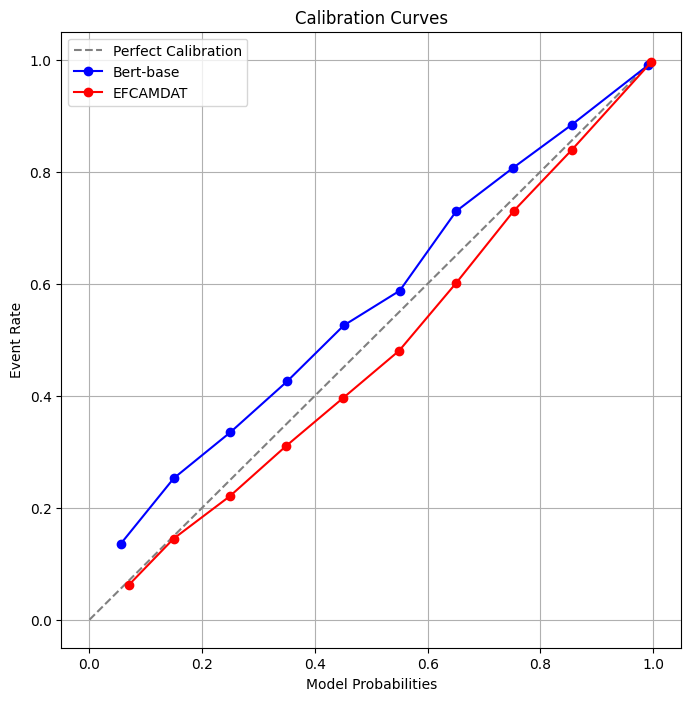

In [ ]:
def compute_ece(probabilities, labels, num_bins=10):
    """
    Calculer les données pour la courbe de calibration d'un modèle.

    Arguments :
    - probabilities : Tensor contenant les probabilités prédites pour la classe correcte.
    - labels : Tensor contenant les étiquettes réelles (0 ou 1 pour les tâches binaires).
    - num_bins : Nombre de bins (intervalles) pour la calibration.

    Retourne :
    - bin_confidence : Moyenne des probabilités prédites pour chaque bin.
    - bin_accuracy : Taux de précision (accuracy) pour chaque bin.
    - bin_counts : Nombre d'échantillons dans chaque bin.
    """
    # Définir les bornes des bins pour diviser les probabilités en intervalles.
    bin_boundaries = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(probabilities, bin_boundaries, right=True) - 1

    bin_accuracy = []
    bin_confidence = []
    bin_counts = []

    for i in range(num_bins):
        # Identifier les échantillons appartenant au bin courant.
        bin_mask = (bin_indices == i)
        bin_count = bin_mask.sum()
        if bin_count > 0:
            # Extraire les probabilités et les labels des échantillons du bin.
            bin_probs = probabilities[bin_mask]
            bin_labels = labels[bin_mask]
            accuracy = (bin_labels == 1).mean()  # Précision pour les labels binaires.
            confidence = bin_probs.mean()  # Moyenne des probabilités dans le bin.

            # Stocker les résultats.
            bin_accuracy.append(accuracy)
            bin_confidence.append(confidence)
            bin_counts.append(bin_count)

    return bin_confidence, bin_accuracy, bin_counts


def calculate_ece(bin_confidence, bin_accuracy, bin_counts):
    """
    Calculer l'erreur de calibration attendue (Expected Calibration Error, ECE).

    Arguments :
    - bin_confidence : Confiance moyenne pour chaque bin.
    - bin_accuracy : Précision moyenne pour chaque bin.
    - bin_counts : Nombre d'échantillons dans chaque bin.

    Retourne :
    - ece : Erreur de calibration moyenne pondérée par le nombre d'échantillons.
    """
    total_samples = sum(bin_counts)
    ece = 0.0
    for conf, acc, count in zip(bin_confidence, bin_accuracy, bin_counts):
        ece += count * abs(acc - conf)  # Écart pondéré entre précision et confiance.
    ece /= total_samples
    return ece


def plot_calibration_curves(bin_conf_1, bin_acc_1, bin_conf_2, bin_acc_2, model1_name="Model 1", model2_name="Model 2"):
    """
    Tracer les courbes de calibration pour deux modèles.

    Arguments :
    - bin_conf_1, bin_acc_1 : Confiance et précision par bin pour le modèle 1.
    - bin_conf_2, bin_acc_2 : Confiance et précision par bin pour le modèle 2.
    - model1_name, model2_name : Noms des modèles pour l'affichage des légendes.
    """
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Calibration parfaite")

    plt.plot(bin_conf_1, bin_acc_1, marker="o", label=model1_name, color="blue", linestyle="-")
    plt.plot(bin_conf_2, bin_acc_2, marker="o", label=model2_name, color="red", linestyle="-")

    plt.xlabel("Probabilités prédites par le modèle")
    plt.ylabel("Taux d'événements (Event Rate)")
    plt.title("Courbes de calibration")
    plt.legend(loc="best")
    plt.grid(True)

    # Sauvegarder le graphe dans un fichier image.
    plt.savefig(f'/content/drive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/Base_EFCAMDAT_Calibration_Error.png')
    plt.show()


def evaluate_model_calibration(model, data_loader, tokenizer, device, num_bins=10):
    """
    Évaluer la calibration d'un modèle donné.

    Arguments :
    - model : Modèle PyTorch à évaluer.
    - data_loader : DataLoader contenant le jeu de données.
    - tokenizer : Tokenizer utilisé pour le prétraitement des données.
    - device : Périphérique (CPU/GPU) utilisé pour l'évaluation.
    - num_bins : Nombre de bins pour la calibration.

    Retourne :
    - bin_confidence : Confiance moyenne pour chaque bin.
    - bin_accuracy : Précision moyenne pour chaque bin.
    - bin_counts : Nombre d'échantillons dans chaque bin.
    """
    probabilities = []
    correct_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Passage avant (forward pass) pour obtenir les logits.
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Conversion des logits en probabilités.
            probs = torch.softmax(logits, dim=-1)

            # Récupérer les probabilités maximales et les classes prédites.
            max_probs, predictions = torch.max(probs, dim=-1)
            valid_positions = (labels != tokenizer.pad_token_id) & (labels != -100)

            # Collecter les probabilités et les étiquettes valides.
            probabilities.extend(max_probs[valid_positions].cpu().numpy())
            correct_labels.extend((predictions[valid_positions] == labels[valid_positions]).cpu().numpy())

    # Conversion des listes en tableaux numpy.
    probabilities = np.array(probabilities)
    correct_labels = np.array(correct_labels)

    # Calculer les métriques de calibration.
    bin_confidence, bin_accuracy, bin_counts = compute_ece(probabilities, correct_labels, num_bins=num_bins)

    return bin_confidence, bin_accuracy, bin_counts


# Évaluation pour le modèle Bert-base.
bin_confidence_bert_base, bin_accuracy_bert_base, bin_counts_bert_base = evaluate_model_calibration(
    bert_base, data_loader, tokenizer, device
)

# Évaluation pour le modèle EFCAMDAT.
bin_confidence_EFCAMDAT, bin_accuracy_EFCAMDAT, bin_counts_EFCAMDAT = evaluate_model_calibration(
    EFCAMDAT, data_loader, tokenizer, device
)

# Calculer l'ECE pour les deux modèles.
ece_bert_base = calculate_ece(bin_confidence_bert_base, bin_accuracy_bert_base, bin_counts_bert_base)
ece_efcamdat = calculate_ece(bin_confidence_EFCAMDAT, bin_accuracy_EFCAMDAT, bin_counts_EFCAMDAT)

print(f"ECE Bert-base: {ece_bert_base:.4f}")
print(f"ECE EFCAMDAT: {ece_efcamdat:.4f}")

# Tracer les courbes de calibration pour les deux modèles.
plot_calibration_curves(
    bin_confidence_bert_base, bin_accuracy_bert_base,
    bin_confidence_EFCAMDAT, bin_accuracy_EFCAMDAT,
    model1_name="Bert-base", model2_name="EFCAMDAT"
)

In [ ]:
display(eval_results_4_models)

{'Bert-base': {'average_loss': 9.73911548614502,
  'masked_token_accuracy': 0.8871468926553673,
  'k_scores': {'recall@1': 0.8895883777239709,
   'recall@5': 0.9340193704600485,
   'recall@10': 0.9466101694915254}},
 'EFCAMDAT': {'average_loss': 0.2281011837720871,
  'masked_token_accuracy': 0.9235068603712672,
  'k_scores': {'recall@1': 0.921953188054883,
   'recall@5': 0.9528046811945117,
   'recall@10': 0.9615213882163035}},
 'KL_bert_base_probs': array([[0.05100209, 0.9999174 , 0.96757466, ..., 0.02214277, 0.25409502,
         0.35408455],
        [0.02252407, 0.9893947 , 0.9553372 , ..., 0.5689149 , 0.3243103 ,
         0.24834919],
        [0.01500138, 0.9998679 , 0.71195894, ..., 0.6737057 , 0.4890542 ,
         0.26342112],
        ...,
        [0.01021538, 0.9993793 , 0.9863239 , ..., 0.86076576, 0.84984773,
         0.679071  ],
        [0.0157346 , 0.99429023, 0.50210434, ..., 0.9999349 , 0.9993844 ,
         0.34026963],
        [0.01392374, 0.9993629 , 0.9649766 , ..., 0.9

In [ ]:
# Convertir les scores en un DataFrame avec un seul index ("Bert-base")
df_k_scores_bert_base = pd.DataFrame([list(eval_results_4_models["Bert-base"]["k_scores"].values()), list(eval_results_4_models["EFCAMDAT"]["k_scores"].values())],
                                     columns=['Recall@1', 'Recall@5', 'Recall@10'],
                                     index=['Bert-base', 'EFCAMDAT'])

# Affichage du DataFrame
display(df_k_scores_bert_base)
df_k_scores_bert_base.to_csv('/content/drive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/k_scores_bert_base_EFCAMDAT.csv', index=True)


,Recall@1,Recall@5,Recall@10
Bert-base,0.889588,0.934019,0.946610
EFCAMDAT,0.921953,0.952805,0.961521


In [ ]:
with open('/content/drive/MyDrive/Doc_Struct_Projet/TestCorpusScripts/Resultats/eval_results_4_models.pickle', 'wb') as handle:
    pickle.dump(eval_results_4_models, handle, protocol=pickle.HIGHEST_PROTOCOL)